<a href="https://colab.research.google.com/github/srilalithaveerubhotla/TreeBased_Models/blob/main/xgboost_for_otto_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xg
from collections import Counter
!pip install kneed
# kneed is not installed in kaggle. uncomment the above line.
from kneed import KneeLocator
import matplotlib.pyplot as plt
import google_auth_httplib2


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### Loading the dataset and data preprocessing

In [ ]:
# Reading train dataset in the environment.
dataset_pd = pd.read_csv("/content/drive/My Drive/train.csv", index_col = 0)
print(dataset_pd.shape)
# Reading test dataset in the environment.
dataset_pd2 = pd.read_csv("/content/drive/My Drive/test.csv", index_col = 0)
print(dataset_pd2.shape)

(61878, 94)
(144368, 93)


In [ ]:
# Creating a predictor matrix (removing the response variable column)
dataset_train = dataset_pd.values
X = dataset_train[:,0:93] # Predictors
y = dataset_train[:,93] # Response 

# XGBoost do not take a categorical variable as input. We can use LabelEncoder to assign labels to categorical variables.
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoder_y = label_encoder.transform(y)

In [ ]:
# Train and test split of the data
X_train, X_test, y_train, y_test = train_test_split(X, label_encoder_y, test_size = 0.33, random_state = 7)

### XGBoost Model with default settings

In [ ]:
# Running a XGBoost with default settings.
model = xg.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# Check the accuracy of the model on train and test dataset.
accuracy_train = accuracy_score(y_train, model.predict(X_train))
print("Accuracy on train dataset %.2f%%" % (accuracy_train * 100))

accuracy_test = accuracy_score(y_test, model.predict(X_test))
print("Accuracy on test dataset %.2f%%" % (accuracy_test * 100))

Accuracy on train dataset 91.01%
Accuracy on test dataset 81.03%


In [ ]:
# Creating a confusion matrix 
print(confusion_matrix(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

[[ 316   25    4    1    2   54   22   96  106]
 [   5 4543  613   52    8   14   57   13   10]
 [   1 1214 1343   47    1    3   54   10    3]
 [   2  306  127  418    9   25   18    2    2]
 [   0   16    4    0  891    2    4    1    0]
 [  25   25    4    5    1 4384   52   88   50]
 [  12   74   68   11    2   76  636   45    7]
 [  38   33    7    0    1   59   18 2553   36]
 [  53   32    1    1    0   54    5   58 1462]]
              precision    recall  f1-score   support

           0       0.70      0.50      0.59       626
           1       0.72      0.85      0.78      5315
           2       0.62      0.50      0.55      2676
           3       0.78      0.46      0.58       909
           4       0.97      0.97      0.97       918
           5       0.94      0.95      0.94      4634
           6       0.73      0.68      0.71       931
           7       0.89      0.93      0.91      2745
           8       0.87      0.88      0.87      1666

    accuracy             

In [ ]:
# Running a XGBoost with less column sample.
model = xg.XGBClassifier(colsample_bytree = 0.5)
model.fit(X_train, y_train)
# Check the accuracy of the model on train and test dataset.
accuracy_train = accuracy_score(y_train, model.predict(X_train))
print("Accuracy on train dataset %.2f%%" % (accuracy_train * 100))

accuracy_test = accuracy_score(y_test, model.predict(X_test))
print("Accuracy on test dataset %.2f%%" % (accuracy_test * 100))

Accuracy on train dataset 89.92%
Accuracy on test dataset 80.83%


In [ ]:
Counter(y_test)

Counter({8: 1666,
         5: 4634,
         0: 626,
         3: 909,
         1: 5315,
         4: 918,
         7: 2745,
         6: 931,
         2: 2676})

### Studying the feature importance and selecting the top variables.

In [ ]:
# Storing the feature importance matrix
feature_imp = pd.DataFrame(model.feature_importances_, 
                           index = dataset_pd.drop('target', axis = 1).columns, columns = ['imp'])
feature_imp.sort_values(by = 'imp', ascending = False, inplace = True)

In [ ]:
# Calculating accuracy considering different threshold for feature importance.
num = []
score = []
for thresh in model.feature_importances_:
    selection = SelectFromModel(model, threshold = thresh, prefit = True)
    Select_X_train = selection.transform(X_train)
    selection_model = xg.XGBClassifier()
    selection_model.fit(Select_X_train, y_train)
    Select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(Select_X_test)
    num.append(Select_X_train.shape[1])
    score.append(accuracy_score(y_test, y_pred)* 100)
    print("Thresh: %.3f, n = %d, Accuracy: %.2f%%" % (thresh, Select_X_train.shape[1], accuracy_score(y_test, y_pred)* 100))

Thresh: 0.004, n = 62, Accuracy: 80.59%
Thresh: 0.005, n = 49, Accuracy: 79.57%
Thresh: 0.004, n = 64, Accuracy: 80.57%
Thresh: 0.004, n = 63, Accuracy: 80.44%
Thresh: 0.003, n = 77, Accuracy: 80.76%
Thresh: 0.003, n = 89, Accuracy: 81.04%
Thresh: 0.009, n = 28, Accuracy: 75.71%
Thresh: 0.008, n = 34, Accuracy: 77.75%
Thresh: 0.013, n = 20, Accuracy: 73.63%
Thresh: 0.003, n = 82, Accuracy: 81.01%
Thresh: 0.111, n = 1, Accuracy: 38.10%
Thresh: 0.002, n = 93, Accuracy: 81.03%
Thresh: 0.003, n = 74, Accuracy: 80.80%
Thresh: 0.024, n = 10, Accuracy: 64.64%
Thresh: 0.025, n = 8, Accuracy: 60.34%
Thresh: 0.005, n = 59, Accuracy: 80.28%
Thresh: 0.011, n = 24, Accuracy: 75.11%
Thresh: 0.003, n = 80, Accuracy: 80.94%
Thresh: 0.009, n = 31, Accuracy: 76.51%
Thresh: 0.005, n = 56, Accuracy: 80.21%
Thresh: 0.003, n = 75, Accuracy: 80.67%
Thresh: 0.002, n = 91, Accuracy: 80.93%
Thresh: 0.010, n = 27, Accuracy: 75.76%
Thresh: 0.006, n = 47, Accuracy: 79.53%
Thresh: 0.008, n = 37, Accuracy: 78.66%
Th

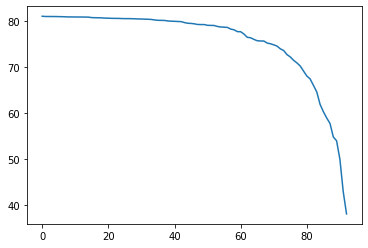

In [ ]:
# Storing the accuracy table for different threshold and then plotting it.
accuracy_table = pd.DataFrame({'params' : num, 'accuracy' : score})
accuracy_table.sort_values(by = 'accuracy', ascending = False, inplace = True)
plt.plot(range(93), accuracy_table['accuracy'])
plt.show()

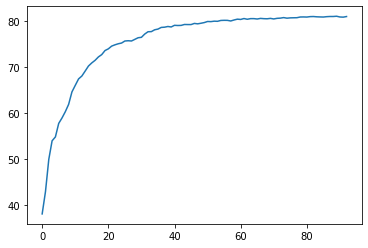

In [ ]:
# Storing the accuracy table for different threshold and then plotting it.
accuracy_table.sort_values(by = 'params', inplace = True)
plt.plot(range(93), accuracy_table['accuracy'])
plt.show()

In [ ]:
# We can find the elbow using KneeLocator.
kl = KneeLocator(range(1, 94), accuracy_table['accuracy'], curve="concave", direction="increasing")
kl.elbow

22

In [ ]:
# We can select 25 top variables and then fit the model again.
feature_imp[:25].index

Index(['feat_11', 'feat_90', 'feat_60', 'feat_34', 'feat_69', 'feat_36',
       'feat_26', 'feat_15', 'feat_39', 'feat_14', 'feat_30', 'feat_68',
       'feat_75', 'feat_42', 'feat_53', 'feat_47', 'feat_40', 'feat_91',
       'feat_86', 'feat_9', 'feat_78', 'feat_59', 'feat_84', 'feat_17',
       'feat_57'],
      dtype='object')

In [ ]:
# Selecting the top 25 variables.
data_top25 = dataset_pd[feature_imp[:25].index]
X_top25 = data_top25.values

In [ ]:
# Train and test split of the data
X_train, X_test, y_train, y_test = train_test_split(X_top25, label_encoder_y, test_size = 0.33, random_state = 7)

In [ ]:
# Running a XGBoost with default settings with only top 25 variables.
model = xg.XGBClassifier()
model.fit(X_train, y_train)

# Check the accuracy of the model on train and test dataset.
accuracy_train = accuracy_score(y_train, model.predict(X_train))
print("Accuracy on train dataset %.2f%%" % (accuracy_train * 100))

accuracy_test = accuracy_score(y_test, model.predict(X_test))
print("Accuracy on test dataset %.2f%%" % (accuracy_test * 100))

Accuracy on train dataset 81.45%
Accuracy on test dataset 75.01%


### Hyperparameter Tuning

Number of trees and size of the tree.

In [ ]:
# Grid Search for number of trees
model = xg.XGBClassifier(n_thread = -1)
n_estimators = range(100, 500, 50)
#max_depth = [2,4,6,8]
param_grid = dict(n_estimators = n_estimators)
kfold = StratifiedKFold(n_splits = 8, shuffle = True, random_state = 7)
grid_search = GridSearchCV(model, param_grid, scoring = "neg_log_loss", n_jobs = -1, cv = kfold, verbose = 3)
result = grid_search.fit(X_top25, label_encoder_y)

Fitting 8 folds for each of 8 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 78.9min finished


[06:56:30] WARNING: /workspace/src/learner.cc:480: 
Parameters: { n_thread } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [ ]:
print("Best paramter is %s " % result.best_params_)

Best paramter is {'n_estimators': 150} 


In [ ]:
# Mean score for all the paramters tested
pd.DataFrame({"params": result.cv_results_['params'], "mean_score": result.cv_results_['mean_test_score'],
             "std_score": result.cv_results_['std_test_score']})

,params,mean_score,std_score
0,{'n_estimators': 100},-0.649558,0.009146
1,{'n_estimators': 150},-0.646608,0.009606
2,{'n_estimators': 200},-0.648438,0.010667
3,{'n_estimators': 250},-0.651808,0.011334
4,{'n_estimators': 300},-0.656364,0.011535
5,{'n_estimators': 350},-0.662481,0.012653
6,{'n_estimators': 400},-0.668584,0.013346
7,{'n_estimators': 450},-0.675704,0.013548


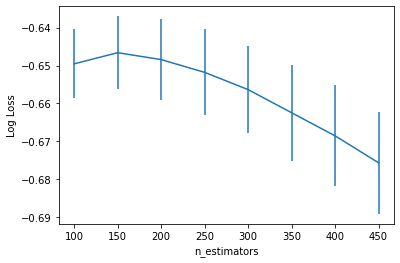

In [ ]:
plt.errorbar(n_estimators, result.cv_results_['mean_test_score'], yerr = result.cv_results_['std_test_score'])
plt.xlabel("n_estimators")
plt.ylabel("Log Loss")
plt.show()

In [ ]:
# Grid Search for learning rate
model = xg.XGBClassifier()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate = learning_rate, n_estimators = [150])
kfold = StratifiedKFold(n_splits = 8, shuffle = True, random_state = 7)
grid_search = GridSearchCV(model, param_grid, scoring = "neg_log_loss", n_jobs = -1, cv = kfold, verbose = 1)
result = grid_search.fit(X, label_encoder_y)

Fitting 8 folds for each of 6 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 106.9min finished


In [ ]:
print("Best paramter is %s " % result.best_params_)
print("Best score is %f" % result.best_score_)

Best paramter is {'learning_rate': 0.3, 'n_estimators': 150} 
Best score is -0.478477


In [ ]:
pd.DataFrame({"params": result.cv_results_['params'], "mean_score": result.cv_results_['mean_test_score'],
             "std_score": result.cv_results_['std_test_score']})

,params,mean_score,std_score
0,"{'learning_rate': 0.0001, 'n_estimators': 150}",-2.162021,0.000148
1,"{'learning_rate': 0.001, 'n_estimators': 150}",-1.907552,0.001285
2,"{'learning_rate': 0.01, 'n_estimators': 150}",-1.000469,0.003573
3,"{'learning_rate': 0.1, 'n_estimators': 150}",-0.513304,0.005049
4,"{'learning_rate': 0.2, 'n_estimators': 150}",-0.482792,0.004714
5,"{'learning_rate': 0.3, 'n_estimators': 150}",-0.478477,0.006044


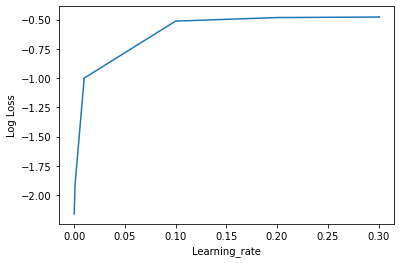

In [ ]:
plt.errorbar(learning_rate, result.cv_results_['mean_test_score'], yerr = result.cv_results_['std_test_score'])
plt.xlabel("Learning_rate")
plt.ylabel("Log Loss")
plt.show()

Now we have optimized 2 paramters, now we will try to build a XGBoost using these new hyperparamters.

First we will try with all the variables and then with top 25 variables.

In [ ]:
# Creating a predictor matrix (removing the response variable column)
dataset_train = dataset_pd.values
X = dataset_train[:,0:93] # Predictors
y = dataset_train[:,93] # Response 

# XGBoost do not take a categorical variable as input. We can use LabelEncoder to assign labels to categorical variables.
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoder_y = label_encoder.transform(y)

# Train and test split of the data
X_train, X_test, y_train, y_test = train_test_split(X, label_encoder_y, test_size = 0.33, random_state = 7)

# Running a XGBoost with less column sample.
model = xg.XGBClassifier(n_estimators = 150, learning_rate = 0.2)
model.fit(X_train, y_train)
# Check the accuracy of the model on train and test dataset.
accuracy_train = accuracy_score(y_train, model.predict(X_train))
print("Accuracy on train dataset %.2f%%" % (accuracy_train * 100))

accuracy_test = accuracy_score(y_test, model.predict(X_test))
print("Accuracy on test dataset %.2f%%" % (accuracy_test * 100))

Accuracy on train dataset 90.91%
Accuracy on test dataset 81.03%


In [ ]:
# Train and test split of the data
X_train, X_test, y_train, y_test = train_test_split(X_top25, label_encoder_y, test_size = 0.33, random_state = 7)

# Running a XGBoost with less column sample.
model = xg.XGBClassifier(n_estimators = 150, learning_rate = 0.2)
model.fit(X_train, y_train)
# Check the accuracy of the model on train and test dataset.
accuracy_train = accuracy_score(y_train, model.predict(X_train))
print("Accuracy on train dataset %.2f%%" % (accuracy_train * 100))

accuracy_test = accuracy_score(y_test, model.predict(X_test))
print("Accuracy on test dataset %.2f%%" % (accuracy_test * 100))

Accuracy on train dataset 81.23%
Accuracy on test dataset 75.40%


In [ ]:
# Train and test split of the data
X_train, X_test, y_train, y_test = train_test_split(X_top25, label_encoder_y, test_size = 0.33, random_state = 7)

# Running a XGBoost with less column sample.
model = xg.XGBClassifier(n_estimators = 150, learning_rate = 0.2, colsample_bytree = 0.7)
model.fit(X_train, y_train)
# Check the accuracy of the model on train and test dataset.
accuracy_train = accuracy_score(y_train, model.predict(X_train))
print("Accuracy on train dataset %.2f%%" % (accuracy_train * 100))

accuracy_test = accuracy_score(y_test, model.predict(X_test))
print("Accuracy on test dataset %.2f%%" % (accuracy_test * 100))

Accuracy on train dataset 80.69%
Accuracy on test dataset 75.26%


In [ ]:
dataset_test = dataset_pd2.values
# Selecting the top 25 variables.
data_top25_test = dataset_pd2[feature_imp[:25].index]
dataset_test = data_top25_test.values
prediction_sub = model.predict(dataset_test)

#dataset_pd2["prediction"] = prediction_sub
X_sub = np.array(prediction_sub).reshape(-1,1)
onehot_encoder = OneHotEncoder(sparse = False)
submission_file = onehot_encoder.fit_transform(X_sub)

submission_file_df = pd.DataFrame(submission_file, 
                                  columns = ['Class_1','Class_2','Class_3','Class_4','Class_5','Class_6',
                                            'Class_7','Class_8','Class_9'], index = dataset_pd2.index)

submission_file_df.to_csv("submission_otto_ver2.csv")